In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import mne
import emd
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import signal
from scipy.integrate import simps


def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def string2timestamp(datetime_str):
    return time.mktime(datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timetuple())


def string2obj(datetime_str):
    return datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')


def obj2string(datetime_obj):
    return datetime.datetime.strftime(datetime_obj, '%Y-%m-%d %H:%M:%S')


def obj2timestamp(datetime_obj):
    datetime_str = datetime.datetime.strftime(
        datetime_obj, '%Y-%m-%d %H:%M:%S')
    return time.mktime(datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timetuple())


def timestamp2obj(timestamp):
    return datetime.datetime.utcfromtimestamp(timestamp-4*3600)


def timestamp2string(timestamp):
    datetime_obj = datetime.datetime.utcfromtimestamp(
        timestamp-4*3600)
    return datetime.datetime.strftime(datetime_obj, '%Y-%m-%d %H:%M:%S')


raw_df = pd.read_csv(
    'data/test_Ganglion/OpenBCISession_Wk4ch/BrainFlow-RAW_Wk4ch_4.csv', delimiter='\t', header=None)
raw_df.dropna(inplace=True)
example_df = raw_df.iloc[:, [0, 1, 2, 3, 4, 13]]
example_df.columns = ['Index_0', 'Channel_1',
                      'Channel_2', 'Channel_3', 'Channel_4', 'timestamp']
example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]
example_df


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3392/1353659669.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]


,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp
0,0.0,685.170241,582.470719,-369.148695,-265.622654,2023-02-27 18:24:18.258762
1,1.0,676.628310,602.458614,-424.057906,-366.072627,2023-02-27 18:24:18.272029
2,1.0,442.658299,658.968502,-190.187002,-572.120545,2023-02-27 18:24:18.272029
3,2.0,323.832327,563.266332,-227.112905,-608.126432,2023-02-27 18:24:18.289114
4,2.0,376.110519,748.726101,-193.796006,-612.386178,2023-02-27 18:24:18.289114
...,...,...,...,...,...,...
202185,90.0,295.291281,1945.658643,-296.749842,-724.360653,2023-02-27 18:41:09.170404
202186,91.0,277.530496,2096.561736,-180.373505,-615.890465,2023-02-27 18:41:09.186274
202187,91.0,244.658645,2059.583475,-112.475621,-509.931619,2023-02-27 18:41:09.186274
202188,92.0,441.160469,2123.935934,-102.321793,-521.162539,2023-02-27 18:41:09.186884


## Calculate metrics for entire recordings

In [73]:
def detrend_raw_signal(ts, n_epochs=None, start=0, window=201):
    if not n_epochs:
        n_epochs = ts.shape // window
    ts = ts[start:(start+n_epochs*window)]
    ts_detrended = np.zeros((n_epochs*201,))
    end = start + 200
    for i in range(n_epochs):
        start += i*201
        end = start + 200
        y = ts[(i*201):(i*201+200)]
        x = np.linspace(0, 1.0, 200)
        m, b = np.polyfit(x, y, 1)
        d = y - x*m-b
        ts_detrended[(i*201):(i*201+200)] = d
    return ts_detrended

In [79]:
# first mintue
start_index = np.where(example_df['Index_0'] == 0)[0][240]
minute_length = 201*60
minute_df = example_df.iloc[start_index:(start_index+minute_length), :]
minute_df = minute_df.reset_index(drop=True)
assert minute_df.loc[minute_df.shape[0]-1, 'Index_0'] == 100.0
minute_df

,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp
0,0.0,519.971380,354.426579,-683.694851,-604.087340,2023-02-27 18:28:19.461820
1,1.0,402.020546,165.369026,-668.140607,-581.696559,2023-02-27 18:28:19.462540
2,1.0,626.139660,-75.042963,-762.300068,-705.517167,2023-02-27 18:28:19.462540
3,2.0,527.862569,-113.451735,-756.503223,-713.520553,2023-02-27 18:28:19.476267
4,2.0,338.217852,-338.030857,-677.355720,-591.259483,2023-02-27 18:28:19.476267
...,...,...,...,...,...,...
12055,98.0,221.142154,970.573227,1038.721684,2107.360697,2023-02-27 18:29:19.732307
12056,99.0,270.082485,1045.879852,1095.089456,2196.224460,2023-02-27 18:29:19.748080
12057,99.0,53.291704,903.763654,1112.990487,2179.091978,2023-02-27 18:29:19.748080
12058,100.0,259.270434,1001.573257,969.200683,2025.458758,2023-02-27 18:29:19.748744


In [94]:
# 60 seconds
def channel_filtering(minute_df, channel_name = 'Channel_1', plot_emd = False):
    n_epochs = 60
    start = 0
    low = 1
    high = 25
    sos = signal.cheby2(N=10,
                        rs=40,
                        Wn=[low, high],
                        btype='bandpass',
                        fs=200,
                        output='sos')
    detrended = detrend_raw_signal(
        minute_df.loc[:, channel_name].to_numpy(),
        n_epochs=n_epochs,
        start=start)
    filtered_detrended = signal.sosfilt(sos, detrended)
    imf = emd.sift.sift(filtered_detrended)
    if plot_emd:
        emd.plotting.plot_imfs(imf)
    # reconstructed_signal = imf[:, 1] + imf[:, 2] + imf[:, 3]
    # reconstructed_signal = imf[:, 0] + imf[:, 1] + imf[:, 2]
    reconstructed_signal = imf[:, 0] + imf[:, 1]
    return reconstructed_signal, filtered_detrended

In [80]:
reconstructed_Channel_1, filtered_Channel_1 = channel_filtering(
    minute_df, channel_name='Channel_1'
)
minute_df['reconstructed_Channel_1'] = reconstructed_Channel_1
minute_df['filtered_Channel_1'] = filtered_Channel_1

reconstructed_Channel_2, filtered_Channel_2 = channel_filtering(
    minute_df, channel_name='Channel_2'
)
minute_df['reconstructed_Channel_2'] = reconstructed_Channel_2
minute_df['filtered_Channel_2'] = filtered_Channel_2

reconstructed_Channel_3, filtered_Channel_3 = channel_filtering(
    minute_df, channel_name='Channel_3'
)
minute_df['reconstructed_Channel_3'] = reconstructed_Channel_3
minute_df['filtered_Channel_3'] = filtered_Channel_3

reconstructed_Channel_4, filtered_Channel_4 = channel_filtering(
    minute_df, channel_name='Channel_4'
)
minute_df['reconstructed_Channel_4'] = reconstructed_Channel_4
minute_df['filtered_Channel_4'] = filtered_Channel_4

minute_df

,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp,reconstructed_Channel_1,filtered_Channel_1,reconstructed_Channel_2,filtered_Channel_2,reconstructed_Channel_3,filtered_Channel_3,reconstructed_Channel_4,filtered_Channel_4
0,0.0,519.971380,354.426579,-683.694851,-604.087340,2023-02-27 18:28:19.461820,-176.816202,10.729819,943.073799,23.282569,84.090772,-2.547884,104.613968,-2.939211
1,1.0,402.020546,165.369026,-668.140607,-581.696559,2023-02-27 18:28:19.462540,-164.880497,31.882102,995.577593,70.609922,73.877073,-7.884176,92.798056,-9.014100
2,1.0,626.139660,-75.042963,-762.300068,-705.517167,2023-02-27 18:28:19.462540,-132.313598,73.169242,1079.960332,151.357503,57.589074,-19.169752,73.843469,-22.106302
3,2.0,527.862569,-113.451735,-756.503223,-713.520553,2023-02-27 18:28:19.476267,-81.393632,132.271442,1193.006142,262.350865,35.049035,-36.602452,47.307433,-42.683299
4,2.0,338.217852,-338.030857,-677.355720,-591.259483,2023-02-27 18:28:19.476267,-13.681439,207.478229,1327.582102,396.498513,6.564107,-59.895222,13.874453,-70.085292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,98.0,221.142154,970.573227,1038.721684,2107.360697,2023-02-27 18:29:19.732307,-58.639112,-63.430962,-32.457290,-39.186400,-7.874799,11.689390,-10.040539,-161.301627
12056,99.0,270.082485,1045.879852,1095.089456,2196.224460,2023-02-27 18:29:19.748080,72.381946,62.070940,89.011031,83.117375,-159.616098,-140.359882,-143.775682,-298.271080
12057,99.0,53.291704,903.763654,1112.990487,2179.091978,2023-02-27 18:29:19.748080,144.065884,126.938287,175.464188,170.273573,-232.448576,-213.496160,-202.427450,-359.073956
12058,100.0,259.270434,1001.573257,969.200683,2025.458758,2023-02-27 18:29:19.748744,141.264768,116.142273,199.325291,194.697587,-195.001302,-176.344408,-158.360754,-316.058788


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3392/1630013983.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


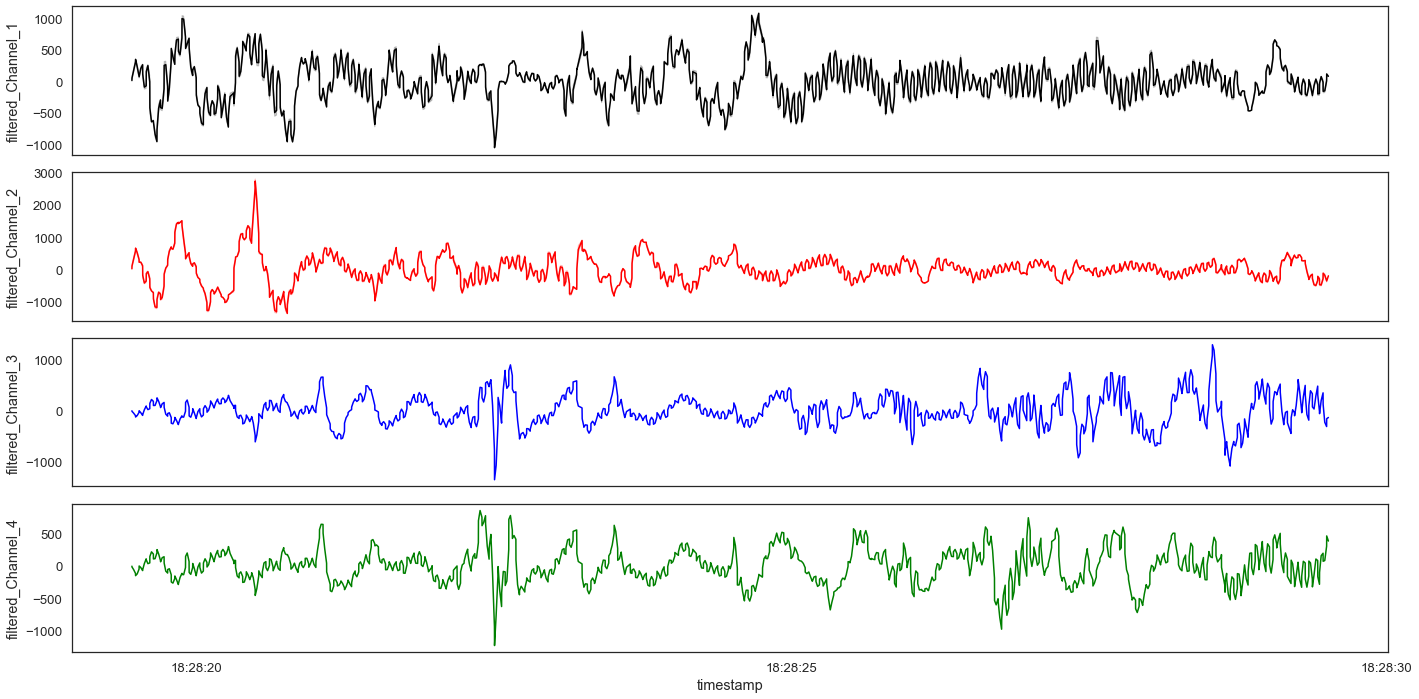

In [81]:
end_index = 2010
fig, ax = plt.subplots(4, 1,
                       figsize=(20, 10),
                       sharex=True)
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'filtered_Channel_1'],
             color='black', ax=ax[0])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'filtered_Channel_2'],
             color='red', ax=ax[1])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'filtered_Channel_3'],
             ci=None,
             color='blue', ax=ax[2])
sns.lineplot(x=minute_df.loc[:end_index, 'timestamp'],
             y=minute_df.loc[:end_index, 'filtered_Channel_4'],
             ci=None,
             color='green', ax=ax[3])

fig.tight_layout(pad=1.2)
fig.show()
filename = 'Working_all_filtered_Channels_4minute.png'
plt.savefig(filename)


(0.0, 30.0)

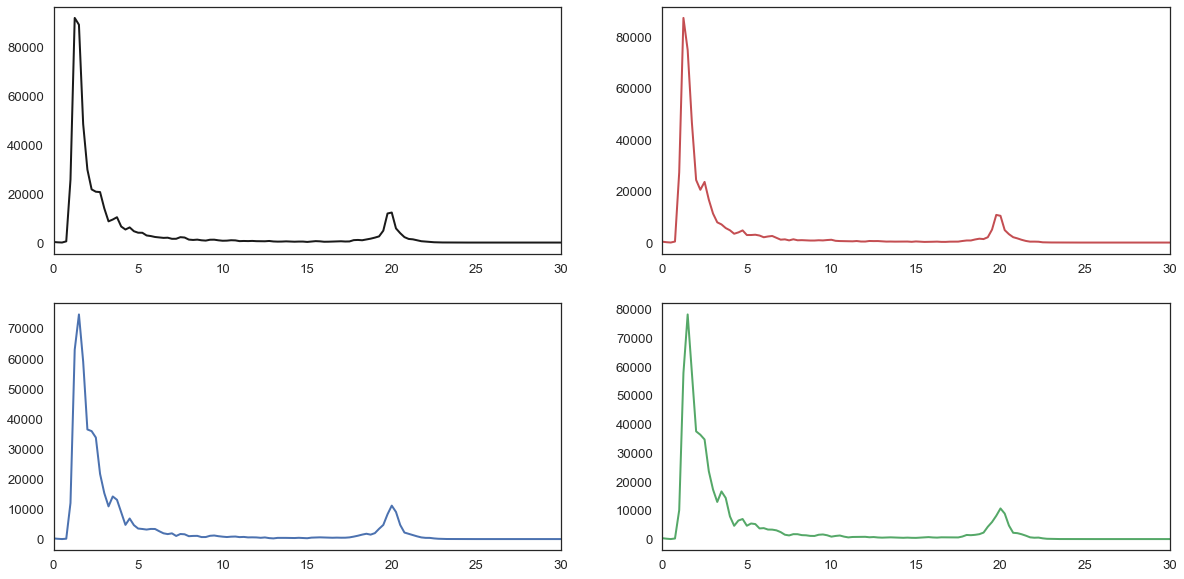

In [78]:
# calculate features
sf = 200

fig, axs = plt.subplots(2, 2,
                       figsize=(20, 10),
                       sharex=False)

# Define window length (4 seconds)
win = 4 * sf
# Plot the power spectrum for channel 1
freqs_1, psd_1 = signal.welch(minute_df['filtered_Channel_1'], sf, nperseg=win)
axs[0, 0].plot(freqs_1, psd_1, color='k', lw=2)
axs[0, 0].set_xlim([0, 30])

# Plot the power spectrum for channel 2
freqs_2, psd_2 = signal.welch(minute_df['filtered_Channel_2'], sf, nperseg=win)
axs[0, 1].plot(freqs_2, psd_2, color='r', lw=2)
axs[0, 1].set_xlim([0, 30])

# Plot the power spectrum for channel 3
freqs_3, psd_3 = signal.welch(minute_df['filtered_Channel_3'], sf, nperseg=win)
axs[1, 0].plot(freqs_3, psd_3, color='b', lw=2)
axs[1, 0].set_xlim([0, 30])

# Plot the power spectrum for channel 4
freqs_4, psd_4 = signal.welch(minute_df['filtered_Channel_4'], sf, nperseg=win)
axs[1, 1].plot(freqs_4, psd_4, color='g', lw=2)
axs[1, 1].set_xlim([0, 30])


In [52]:
def calculate_band_power(x, low, high, sf=200):
    win = 4 * sf
    freqs, psd = signal.welch(x, sf, nperseg=win)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    freq_res = freqs[1] - freqs[0]
    band_power = simps(psd[idx_band], dx=freq_res)
    total_power = simps(psd, dx=freq_res)
    band_rel_power = band_power / total_power
    return band_power, band_rel_power

def band_power_features(segment_df):
    # minute_df must contain filtered signals from all channels
    features_dict = {}
    frequency_bands = {"delta": {'low':1, 'high':4},
                       "theta": {'low': 4, 'high': 8},
                       "alpha": {'low': 8, 'high': 12},
                       "beta": {'low': 12, 'high': 25},
                       }
    # features for channel_1
    delta_power_1, delta_rel_power_1 = calculate_band_power(
        x = segment_df['filtered_Channel_1'],
        low = frequency_bands['delta']['low'],
        high = frequency_bands['delta']['high']
        )
    theta_power_1, theta_rel_power_1 = calculate_band_power(
        x=segment_df['filtered_Channel_1'],
        low=frequency_bands['theta']['low'],
        high=frequency_bands['theta']['high']
    )
    alpha_power_1, alpha_rel_power_1 = calculate_band_power(
        x=segment_df['filtered_Channel_1'],
        low=frequency_bands['alpha']['low'],
        high=frequency_bands['alpha']['high']
    )
    beta_power_1, beta_rel_power_1 = calculate_band_power(
        x=segment_df['filtered_Channel_1'],
        low=frequency_bands['beta']['low'],
        high=frequency_bands['beta']['high']
    )

    features_dict.update({  'Channel_1_delta_power':      delta_power_1,
                            'Channel_1_delta_rel_power':  delta_rel_power_1,
                            'Channel_1_theta_power':      theta_power_1,
                            'Channel_1_theta_rel_power':  theta_rel_power_1,
                            'Channel_1_alpha_power':      alpha_power_1,
                            'Channel_1_alpha_rel_power':  alpha_rel_power_1,
                            'Channel_1_beta_power':       beta_power_1,
                            'Channel_1_beta_rel_power':   beta_rel_power_1,
                          })
    
    # features for channel_2
    delta_power_2, delta_rel_power_2 = calculate_band_power(
        x=segment_df['filtered_Channel_2'],
        low=frequency_bands['delta']['low'],
        high=frequency_bands['delta']['high']
    )
    theta_power_2, theta_rel_power_2 = calculate_band_power(
        x=segment_df['filtered_Channel_2'],
        low=frequency_bands['theta']['low'],
        high=frequency_bands['theta']['high']
    )
    alpha_power_2, alpha_rel_power_2 = calculate_band_power(
        x=segment_df['filtered_Channel_2'],
        low=frequency_bands['alpha']['low'],
        high=frequency_bands['alpha']['high']
    )
    beta_power_2, beta_rel_power_2 = calculate_band_power(
        x=segment_df['filtered_Channel_2'],
        low=frequency_bands['beta']['low'],
        high=frequency_bands['beta']['high']
    )

    features_dict.update({'Channel_2_delta_power':      delta_power_2,
                          'Channel_2_delta_rel_power':  delta_rel_power_2,
                          'Channel_2_theta_power':      theta_power_2,
                          'Channel_2_theta_rel_power':  theta_rel_power_2,
                          'Channel_2_alpha_power':      alpha_power_2,
                          'Channel_2_alpha_rel_power':  alpha_rel_power_2,
                          'Channel_2_beta_power':       beta_power_2,
                          'Channel_2_beta_rel_power':   beta_rel_power_2,
                          })
    
    # features for channel_3
    delta_power_3, delta_rel_power_3 = calculate_band_power(
        x=segment_df['filtered_Channel_3'],
        low=frequency_bands['delta']['low'],
        high=frequency_bands['delta']['high']
    )
    theta_power_3, theta_rel_power_3 = calculate_band_power(
        x=segment_df['filtered_Channel_3'],
        low=frequency_bands['theta']['low'],
        high=frequency_bands['theta']['high']
    )
    alpha_power_3, alpha_rel_power_3 = calculate_band_power(
        x=segment_df['filtered_Channel_3'],
        low=frequency_bands['alpha']['low'],
        high=frequency_bands['alpha']['high']
    )
    beta_power_3, beta_rel_power_3 = calculate_band_power(
        x=segment_df['filtered_Channel_3'],
        low=frequency_bands['beta']['low'],
        high=frequency_bands['beta']['high']
    )

    features_dict.update({'Channel_3_delta_power':      delta_power_3,
                          'Channel_3_delta_rel_power':  delta_rel_power_3,
                          'Channel_3_theta_power':      theta_power_3,
                          'Channel_3_theta_rel_power':  theta_rel_power_3,
                          'Channel_3_alpha_power':      alpha_power_3,
                          'Channel_3_alpha_rel_power':  alpha_rel_power_3,
                          'Channel_3_beta_power':       beta_power_3,
                          'Channel_3_beta_rel_power':   beta_rel_power_3,
                          })
    
    # features for channel_4
    delta_power_4, delta_rel_power_4 = calculate_band_power(
        x=segment_df['filtered_Channel_4'],
        low=frequency_bands['delta']['low'],
        high=frequency_bands['delta']['high']
    )
    theta_power_4, theta_rel_power_4 = calculate_band_power(
        x=segment_df['filtered_Channel_4'],
        low=frequency_bands['theta']['low'],
        high=frequency_bands['theta']['high']
    )
    alpha_power_4, alpha_rel_power_4 = calculate_band_power(
        x=segment_df['filtered_Channel_4'],
        low=frequency_bands['alpha']['low'],
        high=frequency_bands['alpha']['high']
    )
    beta_power_4, beta_rel_power_4 = calculate_band_power(
        x=segment_df['filtered_Channel_4'],
        low=frequency_bands['beta']['low'],
        high=frequency_bands['beta']['high']
    )

    features_dict.update({'Channel_4_delta_power':      delta_power_4,
                          'Channel_4_delta_rel_power':  delta_rel_power_4,
                          'Channel_4_theta_power':      theta_power_4,
                          'Channel_4_theta_rel_power':  theta_rel_power_4,
                          'Channel_4_alpha_power':      alpha_power_4,
                          'Channel_4_alpha_rel_power':  alpha_rel_power_4,
                          'Channel_4_beta_power':       beta_power_4,
                          'Channel_4_beta_rel_power':   beta_rel_power_4,
                          })
    return features_dict

In [70]:
def segment_minute(df, start_second=0):

    # first mintue
    start_index = np.where(df['Index_0'] == 0)[0][start_second]
    minute_length = 201*60
    minute_df = df.iloc[start_index:(start_index+minute_length), :]
    minute_df = minute_df.reset_index(drop=True)
    assert minute_df.loc[minute_df.shape[0]-1, 'Index_0'] == 100.0

    reconstructed_Channel_1, filtered_Channel_1 = channel_filtering(
        minute_df, channel_name='Channel_1'
    )
    minute_df['reconstructed_Channel_1'] = reconstructed_Channel_1
    minute_df['filtered_Channel_1'] = filtered_Channel_1

    reconstructed_Channel_2, filtered_Channel_2 = channel_filtering(
        minute_df, channel_name='Channel_2'
    )
    minute_df['reconstructed_Channel_2'] = reconstructed_Channel_2
    minute_df['filtered_Channel_2'] = filtered_Channel_2
    reconstructed_Channel_3, filtered_Channel_3 = channel_filtering(
        minute_df, channel_name='Channel_3'
    )
    minute_df['reconstructed_Channel_3'] = reconstructed_Channel_3
    minute_df['filtered_Channel_3'] = filtered_Channel_3
    reconstructed_Channel_4, filtered_Channel_4 = channel_filtering(
        minute_df, channel_name='Channel_4'
    )
    minute_df['reconstructed_Channel_4'] = reconstructed_Channel_4
    minute_df['filtered_Channel_4'] = filtered_Channel_4
    return minute_df

In [97]:
segment_minute(example_df, start_second=120)['filtered_Channel_1']


0         47.980804
1        148.824904
2        329.422663
3        586.686571
4        919.306210
            ...    
12055    346.753925
12056    438.375122
12057    503.677198
12058    513.004375
12059    466.345997
Name: filtered_Channel_1, Length: 12060, dtype: float64

In [108]:
column_names = list(band_power_features(segment_minute(example_df, start_second=0)).keys())
result_df = pd.DataFrame(columns=column_names)
for i in range(0,601,60):
    features_dict = band_power_features(
        segment_minute(example_df, start_second=i))
    result_df = result_df.append(features_dict, ignore_index=True)
result_df.to_csv('working_10_minute_features.csv', index=False)

In [110]:

example_df

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3392/3480336671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]


,Index_0,Channel_1,Channel_2,Channel_3,Channel_4,timestamp
0,0.0,-1040.369110,1346.700575,413.122439,242.066895,2023-02-27 19:48:11.977813
1,1.0,-1272.910479,1274.911325,434.443608,266.170550,2023-02-27 19:48:11.991338
2,1.0,-1238.159329,1471.674942,220.037014,119.545902,2023-02-27 19:48:11.991338
3,2.0,-1467.796666,1404.274465,105.794290,-11.234659,2023-02-27 19:48:12.008024
4,2.0,-1647.160398,1519.755096,296.420731,131.016175,2023-02-27 19:48:12.008024
...,...,...,...,...,...,...
124099,41.0,1260.615558,-622.270734,-621.354458,-726.071657,2023-02-27 19:58:32.464983
124100,42.0,1032.924839,-765.007756,-555.154489,-661.173173,2023-02-27 19:58:32.477068
124101,42.0,1001.663015,-531.948410,-499.766571,-616.384131,2023-02-27 19:58:32.477068
124102,43.0,918.614797,-509.505270,-621.691049,-724.717813,2023-02-27 19:58:32.492809


In [114]:
raw_df = pd.read_csv(
    'data/test_Ganglion/OpenBCISession_Wk4ch/BrainFlow-RAW_Wk4ch_4.csv', delimiter='\t', header=None)
raw_df.dropna(inplace=True)
example_df = raw_df.iloc[:, [0, 1, 2, 3, 4, 13]]
example_df.columns = ['Index_0', 'Channel_1',
                      'Channel_2', 'Channel_3', 'Channel_4', 'timestamp']
example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]
column_names = list(band_power_features(
    segment_minute(example_df, start_second=0)).keys())
result_df = pd.DataFrame(columns=column_names)
for i in range(0, 600, 60):
    features_dict = band_power_features(
        segment_minute(example_df, start_second=i))
    result_df = result_df.append(features_dict, ignore_index=True)
result_df.to_csv('working_10_minute_features.csv', index=False)


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3392/3499716028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]


In [113]:
raw_df = pd.read_csv(
    'data/test_Ganglion/OpenBCISession_Meditating4ch/BrainFlow-RAW_Meditating4ch_1.csv', delimiter='\t', header=None)
raw_df.dropna(inplace=True)
example_df = raw_df.iloc[:, [0, 1, 2, 3, 4, 13]]
example_df.columns = ['Index_0', 'Channel_1',
                      'Channel_2', 'Channel_3', 'Channel_4', 'timestamp']
example_df['timestamp'] = [timestamp2obj(t) for t in example_df['timestamp']]
column_names = list(band_power_features(
    segment_minute(example_df, start_second=0)).keys())
result_df = pd.DataFrame(columns=column_names)
for i in range(0, 600, 60):
    features_dict = band_power_features(
        segment_minute(example_df, start_second=i))
    result_df = result_df.append(features_dict, ignore_index=True)
result_df.to_csv('meditating_10_minute_features.csv', index=False)


Absolute delta power: 48436.587 uV^2
Relative delta power: 0.607


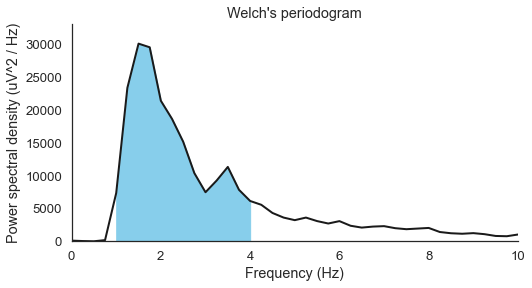

In [46]:
# Define delta lower and upper limits
low, high = 1, 4

#fig, axs = plt.subplots(2, 2,figsize=(20, 10),sharex=False)

# Define window length (4 seconds)
win = 4 * sf

# Plot the power spectrum for channel 1
freqs_1, psd_1 = signal.welch(minute_df['filtered_Channel_1'], sf, nperseg=win)
# Find intersecting values in frequency vector
idx_delta_1 = np.logical_and(freqs_1 >= low, freqs_1 <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(8, 4))
plt.plot(freqs_1, psd_1, lw=2, color='k')
plt.fill_between(freqs_1, psd_1, where=idx_delta_1, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd_1.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

# Frequency resolution
freq_res = freqs_1[1] - freqs_1[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd_1[idx_delta_1], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd_1, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)


Absolute theta power: 12027.593 uV^2
Relative theta power: 0.151


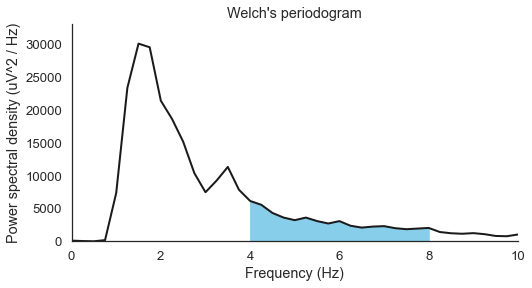

In [48]:
# Define delta lower and upper limits
low, high = 4, 8

#fig, axs = plt.subplots(2, 2,figsize=(20, 10),sharex=False)

# Define window length (4 seconds)
win = 4 * sf

# Plot the power spectrum for channel 1
freqs_1, psd_1 = signal.welch(minute_df['filtered_Channel_1'], sf, nperseg=win)
# Find intersecting values in frequency vector
idx_delta_1 = np.logical_and(freqs_1 >= low, freqs_1 <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(8, 4))
plt.plot(freqs_1, psd_1, lw=2, color='k')
plt.fill_between(freqs_1, psd_1, where=idx_delta_1, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd_1.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

# Frequency resolution
freq_res = freqs_1[1] - freqs_1[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
theta_power = simps(psd_1[idx_delta_1], dx=freq_res)
print('Absolute theta power: %.3f uV^2' % theta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd_1, dx=freq_res)
theta_rel_power = theta_power / total_power
print('Relative theta power: %.3f' % theta_rel_power)




Absolute delta power: 3809.806 uV^2
Relative delta power: 0.048


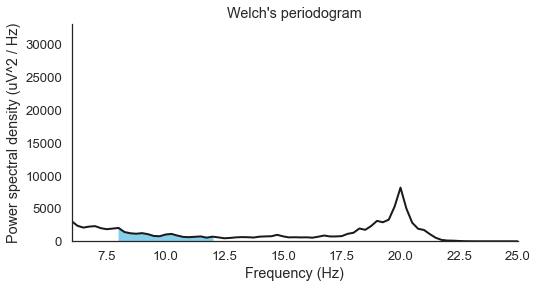

In [49]:
# Define alpha lower and upper limits
low, high = 8, 12

#fig, axs = plt.subplots(2, 2,figsize=(20, 10),sharex=False)

# Define window length (4 seconds)
win = 4 * sf

# Plot the power spectrum for channel 1
freqs_1, psd_1 = signal.welch(minute_df['filtered_Channel_1'], sf, nperseg=win)
# Find intersecting values in frequency vector
idx_delta_1 = np.logical_and(freqs_1 >= low, freqs_1 <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(8, 4))
plt.plot(freqs_1, psd_1, lw=2, color='k')
plt.fill_between(freqs_1, psd_1, where=idx_delta_1, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([6, 25])
plt.ylim([0, psd_1.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

# Frequency resolution
freq_res = freqs_1[1] - freqs_1[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
alpha_power = simps(psd_1[idx_delta_1], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % alpha_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd_1, dx=freq_res)
alpha_rel_power = alpha_power / total_power
print('Relative delta power: %.3f' % alpha_rel_power)


Absolute delta power: 14891.004 uV^2
Relative delta power: 0.186


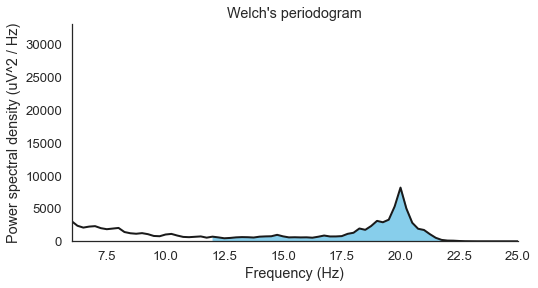

In [50]:
# Define alpha lower and upper limits
low, high = 12, 25

#fig, axs = plt.subplots(2, 2,figsize=(20, 10),sharex=False)

# Define window length (4 seconds)
win = 4 * sf

# Plot the power spectrum for channel 1
freqs_1, psd_1 = signal.welch(minute_df['filtered_Channel_1'], sf, nperseg=win)
# Find intersecting values in frequency vector
idx_delta_1 = np.logical_and(freqs_1 >= low, freqs_1 <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(8, 4))
plt.plot(freqs_1, psd_1, lw=2, color='k')
plt.fill_between(freqs_1, psd_1, where=idx_delta_1, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([6, 25])
plt.ylim([0, psd_1.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

# Frequency resolution
freq_res = freqs_1[1] - freqs_1[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
beta_power = simps(psd_1[idx_delta_1], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % beta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd_1, dx=freq_res)
beta_rel_power = beta_power / total_power
print('Relative delta power: %.3f' % beta_rel_power)


In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / \
    bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / \
    bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)
